In [1]:
import os 
import numpy as np
np.seterr(divide = "ignore")
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataDir = "E:/pythonProgramming/machineLearning_Project/Bank Loan Prediction/DS1"
dataTrain = pd.read_csv(os.path.join(dataDir, "app_train.csv"))
dataTest = pd.read_csv(os.path.join(dataDir, "app_test.csv"))

In [3]:
dataTrain.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dataTrain.drop(["a"], axis=1, inplace=True)

dataTest.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dataTest.drop(["a"], axis=1, inplace=True)

In [4]:
# Separating data with type "object"
categDataTrain = dataTrain.select_dtypes(include="object")
# Get the names of categorically features
categFeatures = categDataTrain.columns

In [5]:
from sklearn.preprocessing import LabelEncoder

def replaceCategValues(data, categFeatures):
    lb = LabelEncoder()
    for feature in categFeatures:
        data[feature] = lb.fit_transform(data[feature])
    return data

In [6]:
dataTrain = replaceCategValues(dataTrain, categFeatures)
dataTest = replaceCategValues(dataTest, categFeatures)

fullData = pd.concat([dataTrain, dataTest], ignore_index=True)

In [7]:
# handle missing values
isnullData = fullData.isnull()
for feature in isnullData.keys():
    if isnullData[feature].value_counts()[False] == isnullData.shape[0]:
        continue
    print(isnullData[feature].value_counts())

False    76263
True         1
Name: ANNUITY, dtype: int64
False    76182
True        82
Name: PRICE, dtype: int64
True     43157
False    33107
Name: EXT_SCORE_1, dtype: int64
False    76111
True       153
Name: EXT_SCORE_2, dtype: int64
False    61106
True     15158
Name: EXT_SCORE_3, dtype: int64


In [8]:
# ====== fill missing value with mean of each feature
fullData.fillna(fullData.mean(), inplace=True)

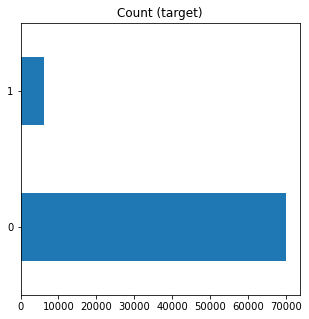

In [9]:
# handle imbalanced data
targetCount = fullData.TARGET.value_counts()

fig, ax= plt.subplots(1, 1, figsize=(5, 5))
targetCount.plot(kind='barh', title='Count (target)')

In [10]:
#  ====== random under-sampling
for i in targetCount.index:
    if targetCount[i] == min(targetCount):
        continue
    print('Abundant class {} size = {}'.format(targetCount.index[i], targetCount[i]))
    frac = min(targetCount)/targetCount[i]
    abundantClass = fullData[fullData.TARGET == i]
    index = abundantClass.sample(frac=1-frac, random_state=42).index
    fullData.drop(index, inplace=True)
print('\nRandom Under-Sampling:')
print(fullData.TARGET.value_counts())

Abundant class 0 size = 70092

Random Under-Sampling:
1    6172
0    6172
Name: TARGET, dtype: int64


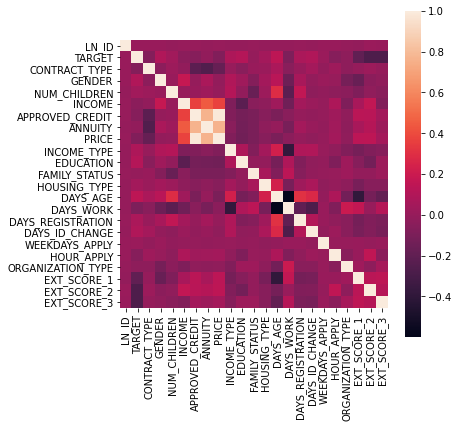

In [11]:
import seaborn as sns

f,ax = plt.subplots(1, 1, figsize=(6,6))
sns.heatmap(fullData.corr(), square=True)

In [12]:
y_data = fullData.TARGET
X_data = fullData.drop(["LN_ID", "TARGET"], axis=1)

In [13]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer()
scaler.fit(X_data)
scaled_X = scaler.transform(X_data)
scaled_X = pd.DataFrame(scaled_X, columns=X_data.columns)

In [14]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

In [15]:
algorithms = []
n_cluster = 3
algorithms.append(("KMEANS", KMeans(n_clusters=n_cluster)))
algorithms.append(("AHC", AgglomerativeClustering(n_clusters=n_cluster)))
# algorithms.append(("DBSCAN", DBSCAN()))
algorithms.append(("GMM", GaussianMixture(n_components=n_cluster)))

In [16]:
clusterOutput = pd.DataFrame()
clusterOutput["LN_ID"] = fullData.LN_ID
for name, algo in algorithms:
    cluster = algo.fit_predict(scaled_X)
    clusterOutput[name] = cluster
clusterOutput.head(10)

LN_ID  KMEANS  AHC  GMM
10  337741       0    2    2
14  297510       0    2    0
57  443396       0    2    0
62  121974       0    2    0
68  338742       0    2    0
69  408296       0    2    0
79  417294       0    2    0
82  348532       0    2    0
87  308035       2    1    2
88  119978       0    2    0

In [17]:
for name, algo in algorithms:
    print(clusterOutput[name].value_counts())
    print("=============")

0    8532
2    2502
1    1310
Name: KMEANS, dtype: int64
2    8044
1    2408
0    1892
Name: AHC, dtype: int64
0    7129
2    3322
1    1893
Name: GMM, dtype: int64


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(scaled_X)
pcaX_train = pca.transform(scaled_X)

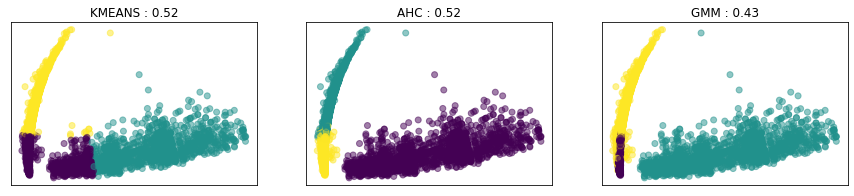

In [19]:
from sklearn.metrics.cluster import silhouette_score

silhouettes = []

fig, axes = plt.subplots(1, 3, figsize=(15, 3), subplot_kw={"xticks": (), "yticks": ()})

for ax, (name, algo) in zip(axes[0:], algorithms):
    clusters = clusterOutput[name]
    silhouette = silhouette_score(scaled_X, clusters)
    silhouettes.append([name, silhouette])

    ax.scatter(pcaX_train[:, 0], pcaX_train[:, 1], c=clusters, alpha=0.5)
    ax.set_title("{} : {:.2f}".format(name, silhouette))

In [20]:
# cluster data with parent data (dataTrain, dataTest)
bestAlgo = max(silhouettes, key=lambda x:x[1])[0]
clusterLabel = clusterOutput[["LN_ID", bestAlgo]]

dataTrain = dataTrain.merge(clusterLabel, how="left", on="LN_ID")
dataTrain.dropna(inplace=True)

dataTest = dataTest.merge(clusterLabel, how="left", on="LN_ID")
dataTest.dropna(inplace=True)